In [2]:
import numpy as np
from scipy.special import expit
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from sklearn.utils import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

In [3]:
class Naive_Bayes():
    def fit(self, xtrain, ytrain):
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.classes = set(self.ytrain)
        self.mean = np.mean(self.xtrain)
        self.std = np.std(self.xtrain)
        self.predictions = []
        self.scores = []
    
    def train(self):
        self.class_mean= np.zeros((len(self.classes), self.xtrain.shape[1]))
        self.class_std = np.zeros((len(self.classes), self.xtrain.shape[1]))
        self.prior = np.zeros((len(self.classes),))
        
        for c in self.classes:
            indx = np.where(self.ytrain == c)
            self.prior[c] = indx[0].shape[0] / float(self.ytrain.shape[0])
            self.class_mean[c] = np.mean(self.xtrain[indx], axis=0)
            self.class_std[c] = np.std(self.xtrain[indx], axis=0)
        
    def predict(self, xtest):
        for xi in xtest:
            tiles = np.repeat([xi], len(self.classes), axis=0)
            E = norm.pdf((self.mean - xi) / self.std) 
            E = np.prod(E)
            
            self.likelihood = norm.pdf((tiles - self.class_mean) / self.class_std)
            self.likelihood = np.prod(self.likelihood, axis=1)
            
            self.post = self.prior * self.likelihood / E
            self.scores.append(1-max(self.post))
            self.predictions.append(np.argmax(self.post))
                
    def accuracy_score(self, ytrue):
        correct = 0
        for i in range(len(ytrue)):
            if ytrue[i] == self.predictions[i]:
                correct += 1
        return (correct/float(len(ytrue))) * 100.0
    
    def get_results(self, ylabel, kFold=False, test=True):
        self.ylabel = ylabel
        thresholds = []
        if kFold:
            conf = confusion_matrix(self.ylabel, self.predictions[18000:])
            plt.figure(0).clf()
            plt.imshow(conf)
            print(classification_report(self.ylabel, self.predictions[:18000]))
            fpr, tpr, thresholds = roc_curve(self.ylabel, self.scores[:18000])
            auc = roc_auc_score(self.ylabel, self.predictions[:18000])
        elif test:
            size = len(ylabel)
            conf = confusion_matrix(self.ylabel, self.predictions[-size:])
            plt.figure(0).clf()
            plt.imshow(conf)
            print(classification_report(self.ylabel, self.predictions[-size:]))
            fpr, tpr, thresholds = roc_curve(self.ylabel, self.scores[-size:])
            auc = roc_auc_score(self.ylabel, self.predictions[-size:])
        else:
            conf = confusion_matrix(self.ylabel, self.predictions)
            plt.figure(0).clf()
            plt.imshow(conf)
            print(classification_report(self.ylabel, self.predictions))
            fpr, tpr, thresholds = roc_curve(self.ylabel, self.scores)
            auc = roc_auc_score(self.ylabel, self.predictions)
        plt.figure(1).clf()

        plt.plot(fpr, tpr, label='Naive Bayes (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC')
        plt.show()

In [4]:
def main(csvX, csvY, kFold=False): 
    dfA = pd.read_csv(csvX)
    dfy = pd.read_csv(csvY)
    dfA = dfA[1:]
           
    names = dfA.columns 
    if 'domain1' in names:
        dfA = dfA.drop(columns=['domain1'])
        dfA = dfA.drop(columns=['state1'])
    else:
        dfA = dfA.drop(columns=['state1'])
        dfA = dfA.drop(columns=['custAttr2'])
 
    dfA = pd.get_dummies(dfA)
    
    X = np.array(dfA)
    y = np.array(dfy)
    pca = PCA(n_components=17)
    pca_vals = pca.fit_transform(X)
    V = pca.components_
    pca_X = np.matmul(X, V[:6, :].T)   
    scaler = StandardScaler()        
    pca_X = scaler.fit_transform(pca_X)

    mask = np.random.rand(len(X)) < 0.8
    
    idx = np.random.permutation(list(range(X.shape[0])))
    if pca:
        pca_X = pca_X[idx, :]
        y = y[idx]
        trX = pca_X[mask]
        testX = pca_X[~mask]
        trY = y[mask]
        testY = y[~mask] 
    else:
        X = X[idx, :]
        y = y[idx]
        trX = X[mask]
        testX = X[~mask]
        trY = y[mask]
        testY = y[~mask] 
        
    trY = np.squeeze(trY)
    testY = np.squeeze(testY)

    ###### 1.1 ######
    if kFold:
        ### train set ###
        size = 18000
        idx = np.random.permutation(list(range(X.shape[0])))
        if pca:
            pca_X = pca_X[idx, :]
            y = y[idx]
            pca_X = pca_X[:90000,:]
            y = y[:90000,:]
        else:
            X = X[idx, :]
            y = y[idx]
            X = X[:90000, :]
            y = y[:90000, :]
        for i in range(4):
            classifier = Naive_Bayes()
            l1 = pca_X[-size:,:]
            l2 = pca_X[:-size,:]
            pca_X = np.vstack((l1,l2)) 
            testX = pca_X[-size:,:]
            testY = y[-size:,:]
            trainX = pca_X[:-size,:]
            trainY = y[:-size,:]
            trainY = np.squeeze(trainY)
            #testY = np.squeeze(testY)

            for i in range(4):
                classifier.fit(trainX[i*size:(i+1)*size,:], trainY[i*size:(i+1)*size])
                classifier.train()
                classifier.predict(trainX[i*size:(i+1)*size,:])
                acc = classifier.accuracy_score(trainY[i*size:(i+1)*size])
                print("Train Accuracy: ", acc, "\tk: ", i+1)
            classifier.predict(testX)
            acc = classifier.accuracy_score(testY)
            print("Test Acc: ", acc)
            classifier.get_results(testY,kFold)
            plt.clf()
            plt.cla()
            plt.close()
            
    else:
        classifier = Naive_Bayes()
        classifier.fit(trX, trY)
        classifier.train()
        classifier.predict(trX)
        acc = classifier.accuracy_score(trY)
        print("Train Accuracy: ", acc)
        
        
        classifier.predict(testX)
        acc = classifier.accuracy_score(testY)
        print("Test Accuracy: ", acc)
        classifier.get_results(testY,False)

Train Accuracy:  97.60555555555555 	k:  1
Train Accuracy:  97.73888888888888 	k:  2
Train Accuracy:  97.95 	k:  3
Train Accuracy:  97.44444444444444 	k:  4
Test Acc:  97.82777777777778
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17644
           1       0.03      0.00      0.01       356

   micro avg       0.98      0.98      0.98     18000
   macro avg       0.50      0.50      0.50     18000
weighted avg       0.96      0.98      0.97     18000



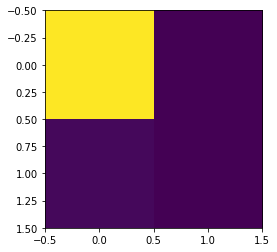

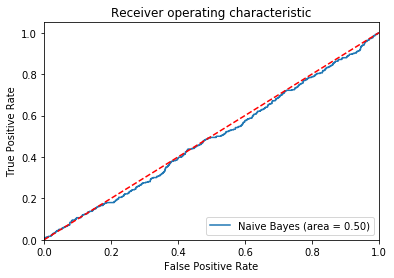

Train Accuracy:  97.60555555555555 	k:  1
Train Accuracy:  97.73888888888888 	k:  2
Train Accuracy:  97.95 	k:  3
Train Accuracy:  97.62222222222222 	k:  4
Test Acc:  98.01666666666667
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17644
           1       0.00      0.00      0.00       356

   micro avg       0.98      0.98      0.98     18000
   macro avg       0.49      0.50      0.49     18000
weighted avg       0.96      0.98      0.97     18000



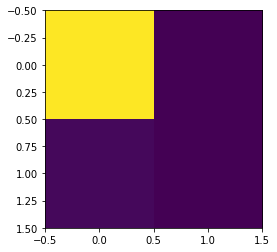

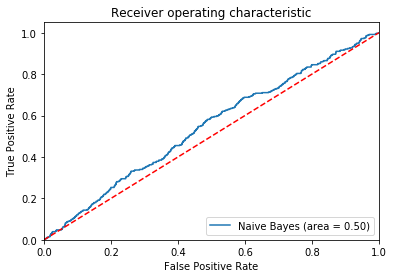

Train Accuracy:  97.60555555555555 	k:  1
Train Accuracy:  97.73888888888888 	k:  2
Train Accuracy:  97.95 	k:  3
Train Accuracy:  97.62777777777778 	k:  4
Test Acc:  98.02222222222223
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17644
           1       0.00      0.00      0.00       356

   micro avg       0.98      0.98      0.98     18000
   macro avg       0.49      0.50      0.50     18000
weighted avg       0.96      0.98      0.97     18000



c:\users\tish\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


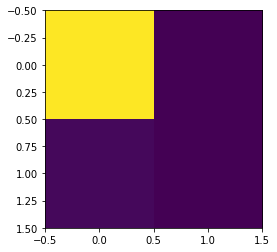

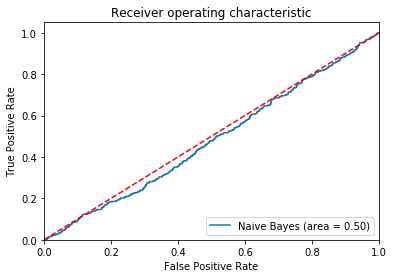

Train Accuracy:  97.38888888888889 	k:  1
Train Accuracy:  97.73888888888888 	k:  2
Train Accuracy:  97.95 	k:  3
Train Accuracy:  97.62777777777778 	k:  4
Test Acc:  98.02222222222223
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17644
           1       0.00      0.00      0.00       356

   micro avg       0.98      0.98      0.98     18000
   macro avg       0.49      0.50      0.50     18000
weighted avg       0.96      0.98      0.97     18000



c:\users\tish\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


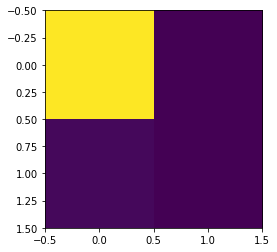

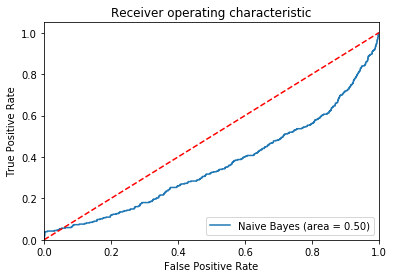

Train Accuracy:  97.4888888888889 	k:  1
Train Accuracy:  97.19444444444446 	k:  2
Train Accuracy:  96.74444444444444 	k:  3
Train Accuracy:  96.60555555555555 	k:  4
Test Acc:  96.71111111111111
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17532
           1       0.03      0.01      0.01       468

   micro avg       0.97      0.97      0.97     18000
   macro avg       0.50      0.50      0.50     18000
weighted avg       0.95      0.97      0.96     18000



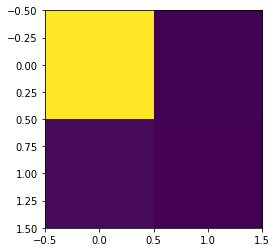

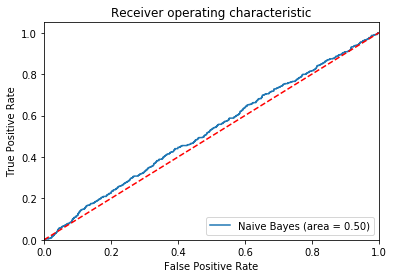

Train Accuracy:  96.95 	k:  1
Train Accuracy:  97.19444444444446 	k:  2
Train Accuracy:  96.92777777777778 	k:  3
Train Accuracy:  97.28333333333333 	k:  4
Test Acc:  97.39999999999999
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17532
           1       0.00      0.00      0.00       468

   micro avg       0.97      0.97      0.97     18000
   macro avg       0.49      0.50      0.49     18000
weighted avg       0.95      0.97      0.96     18000



c:\users\tish\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


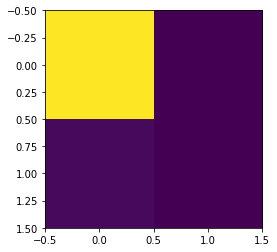

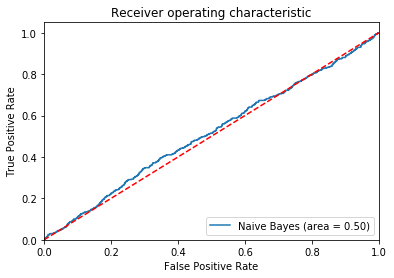

Train Accuracy:  97.4888888888889 	k:  1
Train Accuracy:  97.19444444444446 	k:  2
Train Accuracy:  96.81111111111112 	k:  3
Train Accuracy:  97.28333333333333 	k:  4
Test Acc:  97.39999999999999
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17532
           1       0.00      0.00      0.00       468

   micro avg       0.97      0.97      0.97     18000
   macro avg       0.49      0.50      0.49     18000
weighted avg       0.95      0.97      0.96     18000



c:\users\tish\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


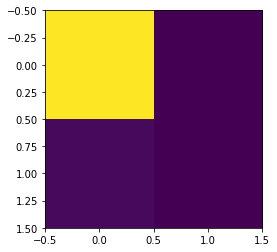

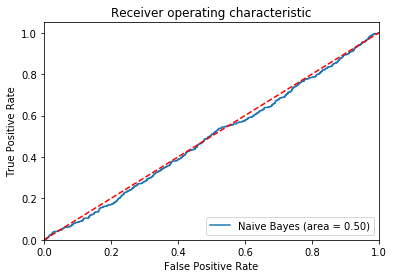

Train Accuracy:  96.91111111111111 	k:  1
Train Accuracy:  97.19444444444446 	k:  2
Train Accuracy:  96.78333333333333 	k:  3
Train Accuracy:  96.74444444444444 	k:  4
Test Acc:  97.71666666666667
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17532
           1       0.77      0.17      0.28       468

   micro avg       0.98      0.98      0.98     18000
   macro avg       0.87      0.59      0.64     18000
weighted avg       0.97      0.98      0.97     18000



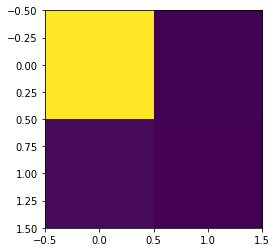

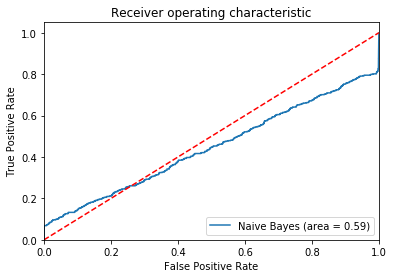

In [5]:
####### Task 2.1 kFold=True SET A and SET B #######
plt.ion()
main(os.path.join(os.getcwd(), "Set-A.X.csv"),os.path.join(os.getcwd(), "Set-A.y.csv"),kFold=True)
main(os.path.join(os.getcwd(), "Set-B.X.csv"),os.path.join(os.getcwd(), "Set-B.y.csv"),kFold=True)

Train Accuracy:  97.49316858738267
Test Accuracy:  97.23689771766695
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18520
           1       0.29      0.08      0.13       408

   micro avg       0.98      0.98      0.98     18928
   macro avg       0.64      0.54      0.56     18928
weighted avg       0.97      0.98      0.97     18928



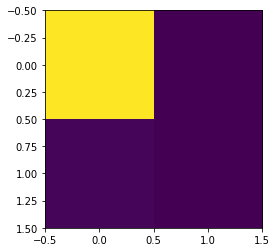

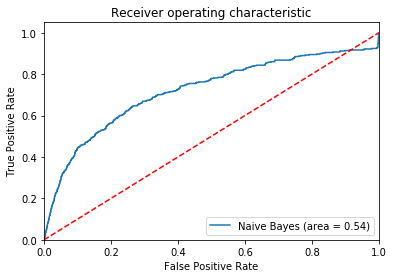

In [6]:
####### Task 2.2 and Task 2.3 Training/Test SET A #######
main(os.path.join(os.getcwd(), "Set-A.X.csv"),os.path.join(os.getcwd(), "Set-A.y.csv"),kFold=False)

Train Accuracy:  97.89193179116988
Test Accuracy:  96.39226629459836
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19522
           1       0.81      0.27      0.41       546

   micro avg       0.98      0.98      0.98     20068
   macro avg       0.89      0.64      0.70     20068
weighted avg       0.98      0.98      0.97     20068



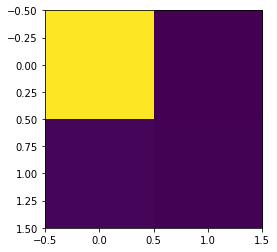

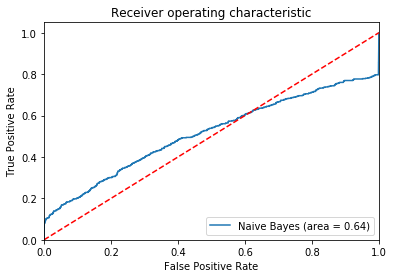

In [7]:
####### Task 2.2 and Task 2.3 Training/Test SET B #######
main(os.path.join(os.getcwd(), "Set-B.X.csv"),os.path.join(os.getcwd(), "Set-B.y.csv"),kFold=False)

###### Task 2.4 ######
The model appears to have similar behavior between train and test sets, so it doesn't suggest overfitting. Again, the issue stems more from the imbalance in the dataset, so it becomes difficult to diagnose other issues when one issue is overshadowing any other quirks in the training. 

###### Task 2.5 ######
I think AdaBoosting would work well here or some kind of ensemble method. For Adaboost, iteratively train the model as in the cross-validation part, but also add a weighting to the ones it predicts wrong and lower the weighting on the ones it get right.